In [29]:
#숫자 처리/그림 그리기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 딥러닝 모델/학습도구
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#이미지 데이터셋과 전처리
import torchvision.datasets as datasets
import torchvision.transforms as transforms

#데이터를 배치(batch)로 꺼내주기
from torch.utils.data import DataLoader
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True' 
#torch와 matplotlib 충돌 시 커널 죽는거 방지



In [2]:
mnist_train=datasets.MNIST(root='../data02/mnist_data',
                           train=True,
                           download=True,
                           transform=transforms.Compose([transforms.ToTensor()]))
mnist_test=datasets.MNIST(root='../data02/mnist_data',
                           train=False,
                           download=True,
                           transform=transforms.Compose([transforms.ToTensor()]))

info는 판다스 전용 메서드고, mnist_train은 torchvision의 MNIST Dataset 객체라서 info가 안됨.
엑셀, csv, 표 형태 데이터(행/열) -> 표가 기본 단위인 것만 판다스로 다뤄.
MNIST는 표 파일이 아니야.


In [3]:
print(mnist_train.data.shape)
print(mnist_train.targets.shape)
print(mnist_test.data.shape)
print(mnist_test.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


훈련 이미지 6만장, 훈련 라벨 6만개


In [4]:
mnist_train.data[1]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [5]:
def plot(x,y):
  plt.figure(figsize=(8,10))
  for i in range(len(x)): #x의 갯수만큼 for문이 돈다
    plt.subplot(5,5, i+1) #행 5, 열 5개 순서는 i번째 +1가 현재 그려지는 차트
    img=(np.array(x[i], dtype='float')).reshape(28,28) # 3차원이면 2차원 이미지로 가져와라
    plt.title(y[i].item())
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  plt.show()

C:\Users\it\AppData\Local\Temp\ipykernel_9244\3778157049.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img=(np.array(x[i], dtype='float')).reshape(28,28) # 3차원이면 2차원 이미지로 가져와라


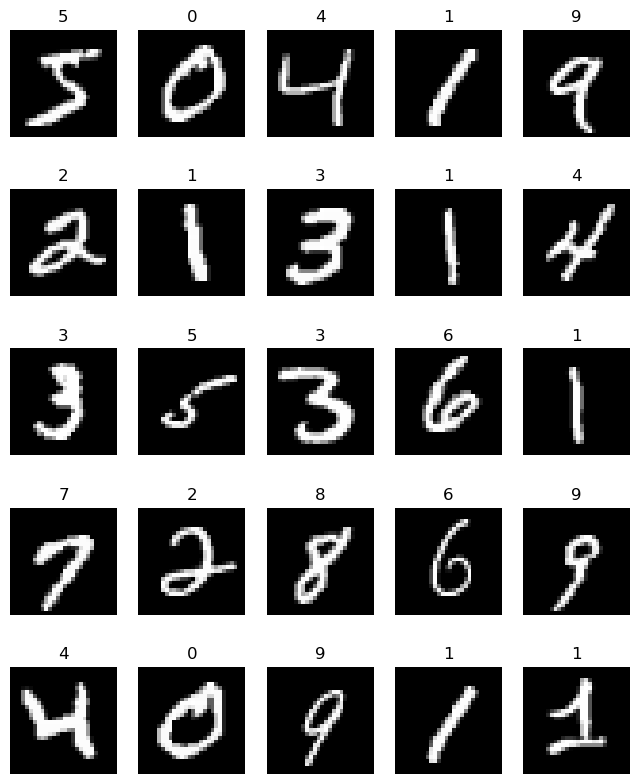

In [6]:
plot(mnist_train.data[:25], mnist_train.targets[:25]) #0~24까지 그려


실제 데이터값을 보자 0번

In [7]:
mnist_train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

픽셀값에 /255 해서 입력을 정규화함.
이 칸을 얼마나 밝냐를 숫자로 적어놓은 지도, 0은 완전검정, 255는 완전 흰색
= 원본 이미지 숫자 표현.

경사하강법의 안정화를 위해 나눈거임. 값이 큼. gradient가 튀어. 값이 작고 일정하면 학습이 안정화됨.

활성함수 relu와 sigmoid는 0~1, -1~1 범위에서 잘 작동해

/255 는 입력하기 좋은 범위로 바꾸는 정규화

In [8]:
x=mnist_train.data.float()/255
y=mnist_train.targets
x[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [9]:
x.size()

torch.Size([60000, 28, 28])

훈련시킬려면 3차원을 2차원으로 만들어야해
view로 만들어준다.

In [10]:
x=x.view(x.size(0),-1) #(0, 1, 2 이고 0은 그대로 쓰라는거, -1 은 28*28 그대로)
print(x.size())

torch.Size([60000, 784])


인풋사이즈를 만든다.

맨 마지막 차원의 값, -1

인풋데이터는 한 데이터의 입력사이즈

In [11]:
input_size=x.size(-1)
print(input_size)

784


제일 큰 값이 9일거래 +1 하면 10
뭐가 9인거야?

In [12]:
output_size=int(max(y))+1
print(output_size)

10


딥러닝에는 벨리데이션 데이터를 구해올거야.
데이터 어떻게 나눌지 비율을 잡았고

In [13]:
ratio = [0.8, 0.2]
train_cnt=int(x.size(0)*ratio[0]) #60000*0.8
valid_cnt=int(x.size(0)*ratio[1]) #60000*0.2
test_cnt=len(mnist_test)
print(train_cnt, valid_cnt, test_cnt) #전체 데이터에서 쪼갰어

48000 12000 10000


그냥 자르지 않고 섞었어.

In [14]:
indices = torch.randperm(x.size(0))
# indices[:20]

#x의 숫자를 랜덤하게 섞어버림, 그중 20개 뽑았어. 한번 섞고 쪼갠다.


섞은거 위치 보정을 했어.

In [15]:
x=torch.index_select(x, dim=0, index=indices) #위의 섞은 인덱스 위치로 재보정??????
y=torch.index_select(y, dim=-1, index=indices) #x도 y도 같이 섞어 din-1은 세로로 섞어??

크기를 나눴어.

In [16]:
cnts = [train_cnt, valid_cnt]

In [17]:
x1=list(x.split(cnts, dim=0))
y1=list(y.split(cnts, dim=0))
print(x1[0].shape, x1[1].shape, y1[0].shape, y1[1].shape)

torch.Size([48000, 784]) torch.Size([12000, 784]) torch.Size([48000]) torch.Size([12000])


데이터를 쪼개놨어.

In [18]:
mnist_test.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

여전히 크니까-

[2] 에는 테스트 데이터가 들어가!

In [19]:
x1+=[(mnist_test.data.float()/255).view(test_cnt, -1)] #3차원 데이터를 2차원으로
print(x1[2].shape)


torch.Size([10000, 784])


In [20]:
y1+=[mnist_test.targets]
print(y1[2].shape)

torch.Size([10000])


모델을 만들어보자!

nn.Linear 이걸 쓸거라서 3차원을 2차원으로 만든거야.
nn.Sequential에 Linear + (Leaky)ReLU를 쌓은 건 신경망(MLP) 구조
이게 회귀인지/분류인지는:

output_size가 무엇인지

마지막 활성화(없을 수도 있음)

loss 함수
이 3개가 결정해.

In [ ]:
model = nn.Sequential(
  nn.Linear(input_size, 500), # 784개의 숫자를 섞어서 500개 숫자를 만든다.
  nn.LeakyReLU(),
  nn.Linear(500, 400),
  nn.LeakyReLU(),
  nn.Linear(400, 200),
  nn.LeakyReLU(),
  nn.Linear(200, 100),
  nn.LeakyReLU(),
  nn.Linear(100, 50),
  nn.LeakyReLU(),
  nn.Linear(50, output_size),
  nn.LeakyReLU(),
  # nn.Softmax()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=200, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=200, out_features=100, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=100, out_features=50, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=50, out_features=10, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
)

소프트 함수 생략한 이유
손실함수를 크로스엔트로피라고 하면 소프트함수를 자동으로 만들어줘

In [22]:
crit=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()) #SGD를 안쓰고 Adam 사용 ㅇㅁㅇ Adam은 lr(rate)을 안잡아줘도 자동으로 세팅

훈련시키자

In [23]:
from copy import deepcopy
epochs=1001 #에폭은 1001번 돌릴거야
batch_size=256 #한번에 256개 넣어
lowest_loss=np.inf #가장 낮은 손실함수 손실함수 무한대???
best_model=None # 지금은 none
early_stop=50 #낮은 손실함수를 구한 후애 50에폭을 더 증가해도 더 낮은게 못찾으면 스탑
# 낮은 손실함수 나오고 나서 50번을 더 증가신킨 후에도 괜찮으면 스탑
# 손실함수 제일 낮은 것을 저장
lowest_epoch=np.inf

In [24]:
train_history, valid_history=[],[]
#손실함수 저장하려고

In [25]:
for epoch in range(epochs):
  indices = torch.randperm(x1[0].size(0)) #[0]은 훈련데이터, 인덱시즈 할거다? 뭔말이지
  x_=torch.index_select(x1[0], dim=0, index=indices) #훈련이미지 섞어
  y_=torch.index_select(y1[0], dim=0, index=indices)
  x_=x_.split(batch_size, dim=0)
  y_=y_.split(batch_size, dim=0) #이미지를 수동으로 256개로 짤라. 리스트 형식으로ㅓ

  train_loss, valid_loss= 0,0
  y_hat=[]

#트레이닝 데이터 제어
  for x_i, y_i in zip(x_, y_):
  #zip 함수는 a=[1,2,3] b=[10,20,30] zip하면 [(1,10), (2,20),(3,30)]으로 튜플의 리스트로 만들어줘.
    y_hat_i=model(x_i)
    loss=crit(y_hat_i, y_i.squeeze()) #1차원을 없애는 스퀴즈 언스퀴지는 크기가 1인 1차원 생산
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss+=float(loss)

    train_loss=train_loss/len(x_) #for문 한번 빠져나올떄마다 

    #벨리드 데이터 제어
  with torch.no_grad(): #기울기 미분 사용 않함.
    x_=x1[1].split(batch_size, dim=0)
    y_=y1[1].split(batch_size, dim=0) 
    valid_loss=0

    for x_i, y_i in zip(x_, y_):
      y_hat_i=model(x_i) #결과가 나온데
      loss=crit(y_hat_i, y_i.squeeze())
      valid_loss+=float(loss)
      y_hat+=[y_hat_i] #벨리데이션 데이터를 y_hat에 리스트형식으로 다 넣음.
    valid_loss=valid_loss/len(x_)

  train_history+=[train_loss]
  valid_history+=[valid_loss]

  if epoch%10==0:
    print(f'epoch:{epoch}, train_loss:{train_loss}, valid_loss:{valid_loss}')
  
  if valid_loss <= lowest_loss:
    lowest_epoch = valid_loss
    lowest_epoch = epoch
    best_model=deepcopy(model.state_dict()) #베스트모델을 카피하는데 상태값 저장

    #가장 낮은 값을 가지게 됨.
  else: #작이 않다면
    if(early_stop >0) and (lowest_epoch + early_stop < epoch):
    #얼리스탑이 0보다는 커졌고 epoch이 50은 지났어.
      print(f'{lowest_epoch} 이후 {early_stop} epoch 증가하는 동안 손실함수 감소 없음')

      break
    
#최소값 찾고 50을 더 지나갔는데 최소값 더 없으면 break로 빠져나가

print(f'epoch {lowest_epoch}일때 손실함수 {lowest_loss}가 검증데이터로 가장 낮은 손실함수를 가짐')

#훈련 끝!!

C:\Users\it\AppData\Local\Temp\ipykernel_9244\4015246772.py:19: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  train_loss+=float(loss)


epoch:0, train_loss:0.0011645088984481252, valid_loss:0.25422753742400633
epoch:10, train_loss:0.00017708741314366704, valid_loss:0.1312902923277084
epoch:20, train_loss:4.1792020851893055e-06, valid_loss:0.12837158749870797
epoch:30, train_loss:2.767239301240473e-05, valid_loss:0.11497960790516214
epoch:40, train_loss:5.620366450176464e-05, valid_loss:0.1454136542421072
epoch:50, train_loss:0.00017877689276767653, valid_loss:0.11904064916629106
epoch:60, train_loss:7.748918459888964e-07, valid_loss:0.13514456366921992
epoch:70, train_loss:2.286910972293489e-06, valid_loss:0.16294195709076334
epoch:80, train_loss:1.0187473538974635e-09, valid_loss:0.15012140394599632
epoch:90, train_loss:5.303120585157417e-09, valid_loss:0.1698490780272937
epoch:100, train_loss:6.771555958874996e-10, valid_loss:0.19005146452555174
epoch:110, train_loss:2.532502887605781e-11, valid_loss:0.2126139084519967
epoch:120, train_loss:5.010066314032227e-13, valid_loss:0.2342305614097797
epoch:130, train_loss:1.

KeyboardInterrupt: 

훈련을 시킬때는 기울기 미분을 해줘야해.
검정할때는 기울기 미분 필요 없어..